In [68]:
%reload_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'IPython.extensions.autoreload'

In [47]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
# import seaborn as sns
# import numpy as np


# from nltk.corpus import stopwordspip
# from wordcloud import WordCloud

In [48]:
# Add parent directory to path to import modules from src
import os
import sys

# Set the parent directory as the root path
rpath = os.path.abspath('..')

# Add the root path to sys.path if it's not already present
if rpath not in sys.path:
    sys.path.insert(0, rpath)

# Import the module from the correct path
from src.loader import SlackDataLoader
import src.utils as utils


### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [49]:
import json
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}/*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            data = json.load(slack_data)
            combined.append(data)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
                     msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall




In [50]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [51]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [52]:
root_dir = "../data/anonymized/"
sl = SlackDataLoader(root_dir)
channels = sl.get_channels()
channel_names = [c['name'] for c in channels]
data_farmes = []
for name in channel_names:
    path = f"{root_dir}{name}"
    df = slack_parser(path)
    data_farmes.append(df)
data = pd.concat(data_farmes, ignore_index=True)

In [53]:
data.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"Hi all, looking forward to starting together, ...",Katherine Foster,1661094957.241139,text,0,0,0,0,0,all-community-building
1,message,Hello everyone. It's my hope that you are doin...,Vanessa Norman,1661151244.337329,text,0,0,0,0,0,all-community-building
2,message,*Community Building Session REMINDER!*:timer_c...,Vanessa Norman,1661169000.633059,text,1661169000.633059,3,2,"U03UG0YHAUT,U03V1AM5TFA",1661169624.405079,all-community-building
3,message,Let's get ready to the first CBS of the progra...,Daniel Brown,1661169461.106859,text,1661169000.633059,0,0,0,0,all-community-building
4,message,The very first CBS is here,Vanessa Norman,1661169547.570659,text,1661169000.633059,0,0,0,0,all-community-building


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [54]:
# which user has the highest number of reply counts?
reply_counts = data.groupby('sender_name')['reply_count'].sum()
sorted_reply_counts = reply_counts.sort_values(ascending=False)
sorted_reply_counts.head(10)

sender_name
Cristian Wilson     620
Vanessa Norman      462
Brian Odom          367
Brenda Hernandez    307
Michelle Lewis      306
April Lucas         302
Travis Butler       299
Amy Leon            282
Joshua Rhodes       247
Brady Rhodes        242
Name: reply_count, dtype: int64

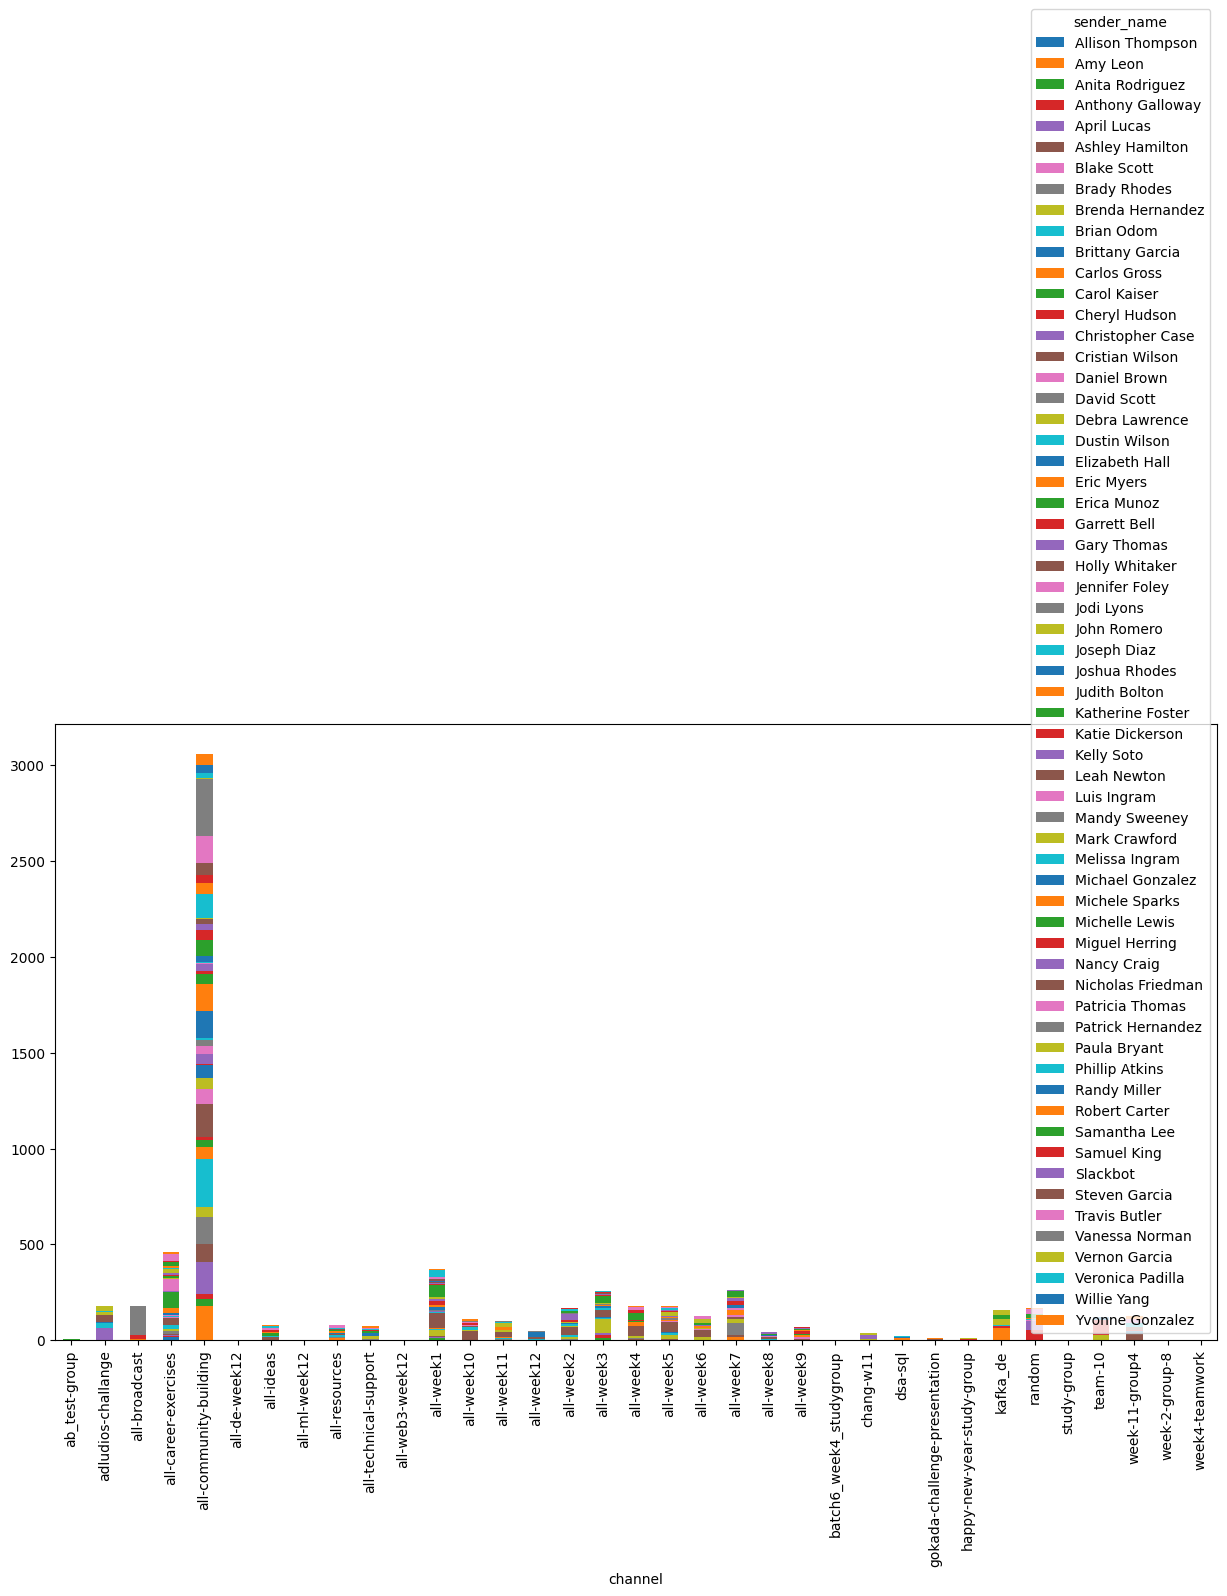

In [55]:
# Visualize reply counts per user per channel
# which user has the highest number of reply counts?
reply_counts_channel = data.groupby(['channel','sender_name'])['reply_count'].sum().unstack()
reply_counts_channel.plot(kind='bar',figsize=(15,8),stacked=True)
plt.show()

In [56]:
# what is the time range of the day that most messages are sent?

timestamps = utils.convert_2_timestamp('msg_sent_time', data)
df_with_timestamps = df.assign(msg_sent_timestamp=timestamps)
df_with_timestamps['hour'] = pd.to_datetime(df_with_timestamps['msg_sent_timestamp']).dt.hour
hourly_counts = df_with_timestamps['hour'].value_counts()
max_hour_count = hourly_counts.max()
most_active_hours = hourly_counts[hourly_counts == max_hour_count].index.tolist()

if most_active_hours:
    min_hour = min(most_active_hours)
    max_hour = max(most_active_hours)
    print(f"The time range of the day with the most messages is from {min_hour}:00 to {max_hour}:59.")
else:
    print("No messages found.")

The time range of the day with the most messages is from 13:00 to 13:59.


In [57]:
# what kind of messages are replied faster than others?

group_by_msgtype = data.groupby(['msg_type','reply_count'])



In [58]:
# Relationship between # of messages and # of reactions



In [59]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [60]:
# Which users got the most reactions?
msg_list = utils.get_messages_dict(data)
reactions_count = {}

for reactions in msg_list["reactions"]:
    if reactions is not None:
        for reaction in reactions:
            user = reaction["user"]
            if user in reactions_count:
                reactions_count[user] += 1
            else:
                reactions_count[user] = 1

if reactions_count:
    max_reactions = max(reactions_count.values())
    users_with_most_reactions = [user for user, count in reactions_count.items() if count == max_reactions]
    print(users_with_most_reactions)
else:
    None


TypeError: string indices must be integers, not 'str'

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?